In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# TF2 INFERNO classifier

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict

import torch.nn as nn
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Nuisances - via interpolation

In [ ]:
tf2_nom = [0.04608, 0.50339, 0.16278, 0.00063, 0.00073, 0.00079, 0.00317, 0.14876, 0.07082, 0.06285]
tf2_up = [[0.05127, 0.47437, 0.16433, 0.0006, 0.00079, 0.00086, 0.00351, 0.16578, 0.07454, 0.06395],
          [0.04621, 0.48761, 0.17753, 0.00092, 0.00105, 0.00117, 0.00505, 0.15305, 0.07124, 0.05617]]
tf2_dw = [[4.1370e-02, 5.3215e-01, 1.6134e-01, 6.5000e-04, 6.2000e-04, 7.7000e-04, 2.9100e-03, 1.3235e-01, 6.6220e-02, 6.1620e-02],
          [4.5490e-02, 5.2118e-01, 1.4547e-01, 3.4000e-04, 4.3000e-04, 4.7000e-04, 1.8800e-03, 1.4384e-01, 7.0000e-02, 7.0900e-02]]
tf2_s = [0.32395, 0.10139, 0.03694, 0.00734, 0.01118, 0.01294, 0.07358, 0.06655, 0.33579, 0.03034]

In [ ]:
b_shapes = OrderedDict([('f_b_nom', Tensor(tf2_nom)), ('f_b_up', Tensor(tf2_up)), ('f_b_dw', Tensor(tf2_dw))])
f_s = Tensor(tf2_s)

## BM0

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
f_b = b_shapes['f_b_nom']
asimov = (50*f_s)+(1000*f_b)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y -= y.min()

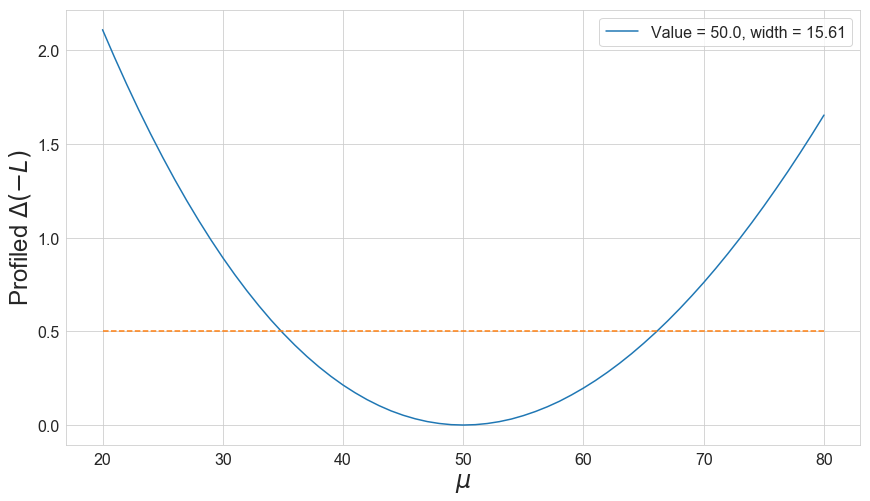

In [ ]:
plot_likelihood(y)

In [ ]:
interp_shape(Tensor((0,0))[None,:], **b_shapes).sum()

tensor(1.)

In [ ]:
interp_shape(Tensor((-1,0))[None,:], **b_shapes)

tensor([[0.0414, 0.5322, 0.1613, 0.0006, 0.0006, 0.0008, 0.0029, 0.1323, 0.0662,
         0.0616]])

In [ ]:
b_shapes['f_b_dw'][1]

tensor([4.5490e-02, 5.2118e-01, 1.4547e-01, 3.4000e-04, 4.3000e-04, 4.7000e-04,
        1.8800e-03, 1.4384e-01, 7.0000e-02, 7.0900e-02])

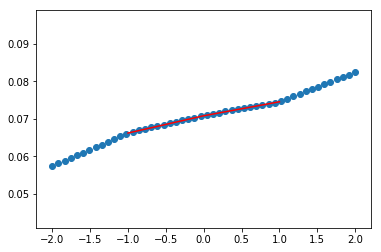

In [ ]:
i = 8
d = b_shapes['f_b_dw'][0][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][0][i]
interp = []
rs = np.linspace(-2,2)
for r in rs: interp.append(interp_shape(Tensor((r,0))[None,:], **b_shapes)[0][i].data.item())
plt.scatter(rs, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

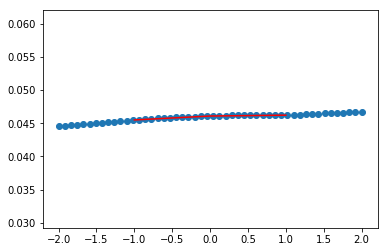

In [ ]:
i = 0
d = b_shapes['f_b_dw'][1][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][1][i]
interp = []
ls = np.linspace(-2,2)
for l in ls: interp.append(interp_shape(Tensor((0,l))[None,:], **b_shapes)[0][i].data.item())
plt.scatter(ls, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

In [ ]:
b_shapes['f_b_nom']

tensor([0.0461, 0.5034, 0.1628, 0.0006, 0.0007, 0.0008, 0.0032, 0.1488, 0.0708,
        0.0628])

In [ ]:
alpha = Tensor((1,0))[None,:]
interp_shape(alpha, **b_shapes).squeeze()

tensor([0.0513, 0.4744, 0.1643, 0.0006, 0.0008, 0.0009, 0.0035, 0.1658, 0.0745,
        0.0640])

In [ ]:
b_shapes['f_b_up']

tensor([[0.0513, 0.4744, 0.1643, 0.0006, 0.0008, 0.0009, 0.0035, 0.1658, 0.0745,
         0.0640],
        [0.0462, 0.4876, 0.1775, 0.0009, 0.0010, 0.0012, 0.0050, 0.1531, 0.0712,
         0.0562]])

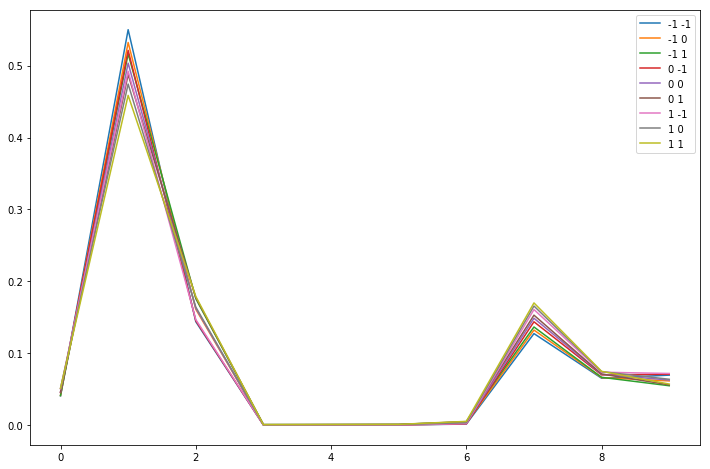

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = likelihood_from_updw(f_s=f_s, n_steps=100, **bm1_b_shapes)

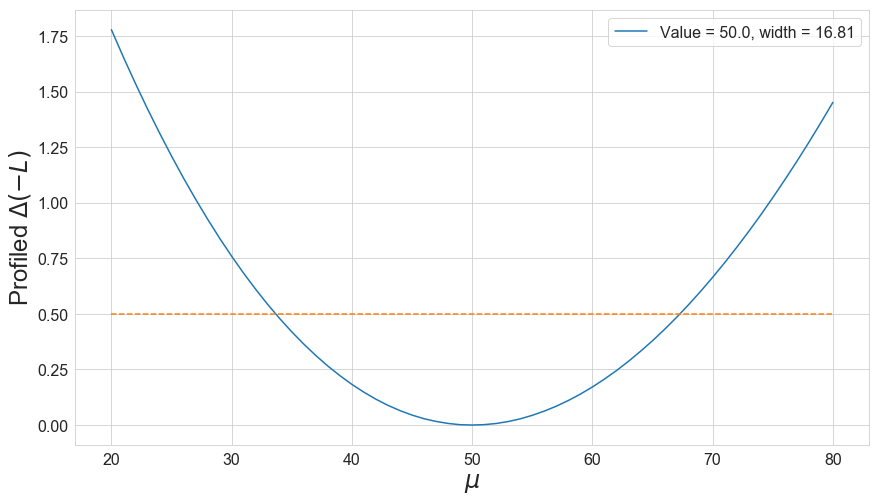

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = likelihood_from_updw(f_s=f_s, n_steps=100, **bm1l_b_shapes)

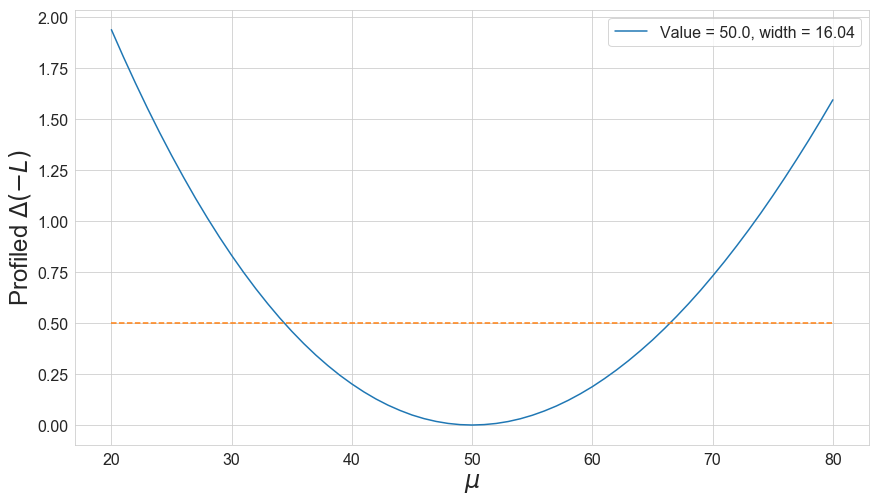

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll = likelihood_from_updw(f_s=f_s, n_steps=100, **b_shapes)

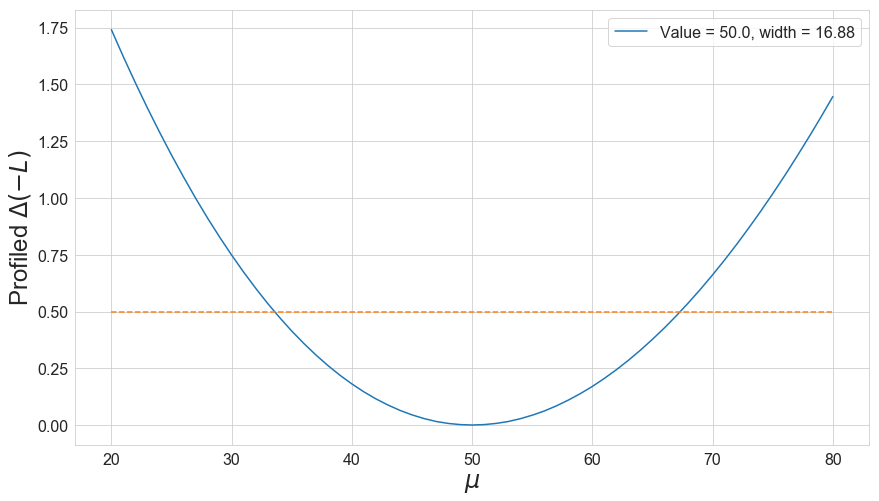

In [ ]:
plot_likelihood(nll-nll.min())

# Random

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = likelihood_from_updw_random(f_s=f_s, n_steps=100, **bm1_b_shapes)

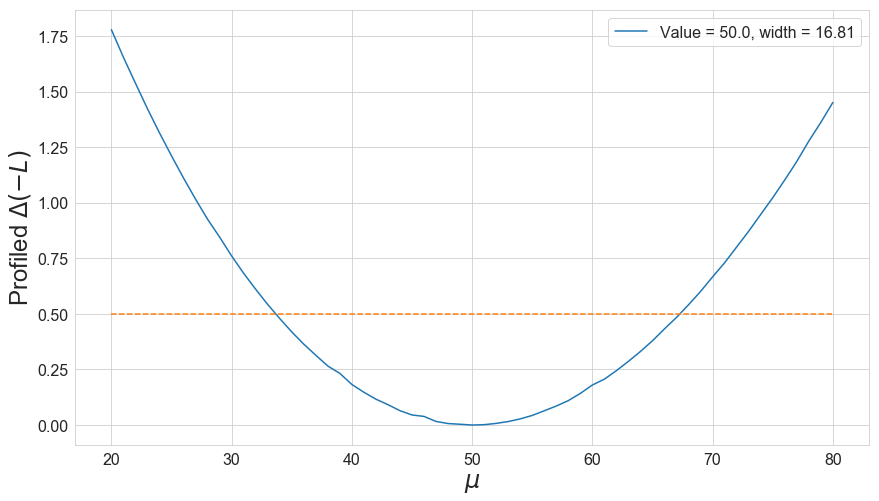

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = likelihood_from_updw_random(f_s=f_s, n_steps=100, **bm1l_b_shapes)

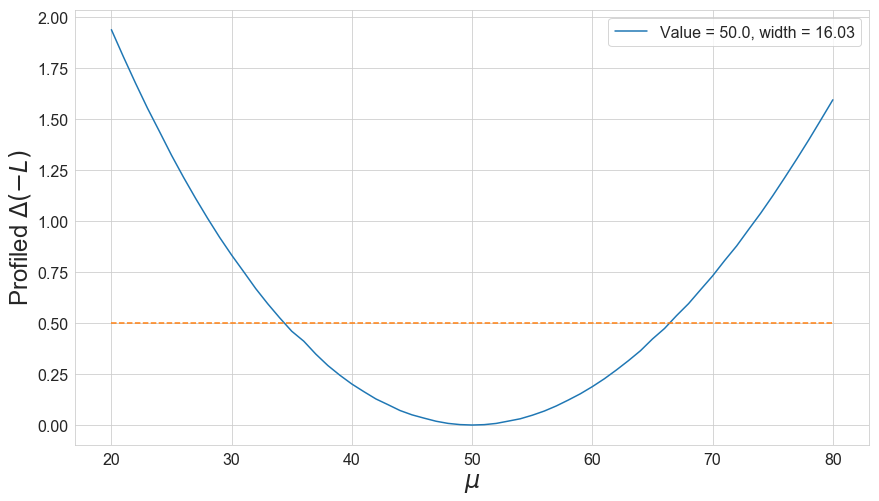

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
import itertools as it
indices = [0,1,2,3]
idx_subset = np.reshape(list(it.product(indices, indices)),
                        (4, 4, -1)).T

In [ ]:
idx_subset

array([[[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]],

       [[0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3]]])

In [ ]:
nll = likelihood_from_updw_random(f_s=f_s, n_steps=1000,
                           f_b_nom=b_shapes['f_b_nom'], f_b_up=b_shapes['f_b_up'], f_b_dw=b_shapes['f_b_dw'])

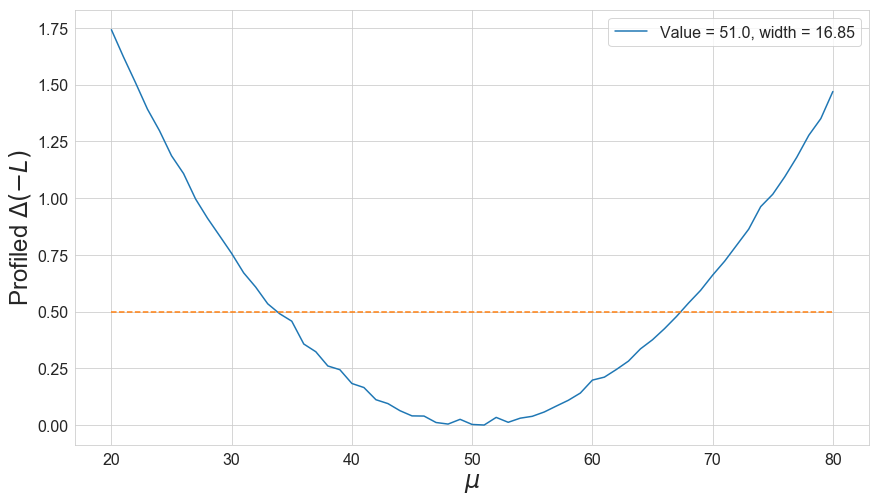

In [ ]:
plot_likelihood(nll-nll.min())